In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from scipy.sparse import rand
import random
import time
from sklearn.model_selection import train_test_split
import sys
sys.path.append('/nas/home2/g/gmialon/research/safe_datapoints')
from tools import *
from screening import *
from experiment import *
import os
from sklearn.datasets import load_diabetes, load_boston, fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import os
import pickle
%matplotlib inline

dir = '/nas/home2/g/gmialon/research/safe_datapoints/results/synthetic'

# Generating the dataset

In [2]:
nb_datapoints = 100
dimension = 500
sparsity = 10

param_set = (nb_datapoints, dimension, sparsity / dimension)
X, y, true_params, noise_norm = make_data(param_set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
dataset=(X, y)

estimator = Lasso(alpha=0.01, fit_intercept=False,
                  max_iter=10000).fit(X_train,y_train)
estimator.score(X_test,y_test)

0.96934163576882837

# Doing the experiment

In [22]:
for dimension in [500]:   
    nb_datapoints = 100
    sparsity = 10
    param_set = (nb_datapoints, dimension, sparsity / dimension)
    X, y, true_params, noise_norm = make_data(param_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    dataset=(X, y)

    estimator = Lasso(alpha=0.01, fit_intercept=False,
                      max_iter=10000).fit(X_train,y_train)
    estimator.score(X_test,y_test)

    for mu in [1, 100, 1000]:
        for n_ell_steps in [1000]:
            for lmbda in [0.001, 0.01, 0.1]:
                experiment(dataset, nb_delete_steps=20, lmbda=lmbda, mu=mu, classification=False, 
                           loss='truncated_squared', penalty='l1', intercept=False, classif_score=False, 
                           n_ellipsoid_steps=n_ell_steps, reverse=False, nb_exp=10, nb_test=5, cluster=False)

Time to compute z and A: 4.984161853790283
Time to rank the entire dataset: 0.06012320518493652
[ 62.40886688  61.59460969  60.63404683  60.50401278  60.27622663
  61.01758098  62.83212945  61.15670659  60.40000449  62.1269954
  59.2985804   64.07327559  60.50660005  61.54244253  62.51023432
  61.995834    61.89383286  60.72324111  61.01878141  60.70174228] [-0.277163   -0.65749092  1.54783269  0.74569686  1.58710092 -0.01380888
 -0.91350557  0.79609044 -1.57874421  0.09064346  0.92078744  1.05858149
 -0.72532624 -1.01764981  0.32631971  0.63095907 -0.01800449 -0.05643364
  1.58737196  0.02523089]
[ -2.95945382e-01   1.93663003e+00  -1.63244756e+00   4.78170263e-01
  -2.72712274e-01   1.99776795e+00   9.20787442e-01  -9.21153094e-01
   1.96534501e+00   2.55468863e+00   1.18771929e+00   4.28788788e-01
  -1.25174550e+00  -2.00774961e+00  -1.32055409e+00  -1.28576846e-01
   4.85450818e-01   1.58710092e+00  -1.57874421e+00  -1.14871451e-01
   7.45696855e-01  -7.25326241e-01  -7.18711724e-0

KeyboardInterrupt: 

In [3]:
def plot_experiment_(data, dataset_size, zoom, name=None, save=False):

    nb_to_del_table = data[0] / dataset_size
    scores_regular_all = np.array(data[1])
    scores_screened_all = np.array(data[2])
    scores_r_all = np.array(data[3])
    idx_not_safe = data[4]

    scores_regular_mean = np.mean(scores_regular_all, 0)
    scores_screened_mean = np.mean(scores_screened_all, 0)
    scores_r_mean = np.mean(scores_r_all, 0)

    scores_regular_var = np.sqrt(np.var(scores_regular_all, 0))
    scores_screened_var = np.sqrt(np.var(scores_screened_all, 0))
    scores_r_var = np.sqrt(np.var(scores_r_all, 0))

    fig, ax1 = plt.subplots(figsize=(14, 8))
    a = ax1.errorbar(nb_to_del_table, scores_regular_mean, yerr=scores_regular_var, linewidth=5, elinewidth=5)
    b = ax1.errorbar(nb_to_del_table, scores_screened_mean, yerr=scores_screened_var, linewidth=5, capsize=10, 
                     markeredgewidth=5, color='orange')
    c = ax1.errorbar(nb_to_del_table, scores_r_mean, yerr=scores_r_var, linewidth=5, capsize=10, markeredgewidth=5, 
                     color='mediumseagreen')
    ax1.legend([a, b, c], ["Trained on whole dataset", "Trained on screened dataset", "Trained on random subset"],
                prop={"size": 25})
    
    if zoom !=None:
        ax1.set_ylim(zoom)
    
    ax1.set_xlabel('Fraction of points deleted', fontsize=45)
    ax1.set_ylabel('Accuracy on test set', fontsize=45)
    ax1.tick_params('y', labelsize=30)
    ax1.tick_params('x', labelsize=30)
    plt.axvline(idx_not_safe / dataset_size, color='tomato', linewidth=5, alpha=0.8)
    #plt.axvline(1 - sparsity * np.log(dimension) / dataset_size, color='cornflowerblue', linewidth=5, alpha=0.8)
    fig.tight_layout()
    ax1.legend()
    if save:
        PATH = '/nas/home2/g/gmialon/research/safe_datapoints/figures/'
        plt.savefig(PATH + name)
        
    plt.show()
    
    return

#exp = 'lmbda_0.01_n_ellipsoid_1000_reverseFalse_intercept_False_mu_1000_classif_score_False_loss_truncated_squared_penalty_l1.npy'
#exp_data = np.load(dir + '/' + exp)
#plot_experiment_(exp_data, 'Lasso ranking', 'synthetic', 'synthetic_ranking.pdf', 80)

# MNIST

In [12]:
boston = load_boston(return_X_y=True)
X = boston[0]
y = boston[1]

In [10]:
def find_best_SVM(X, y):
    param_grid = {'C':[1, 10, 100, 1000, 10000], 'fit_intercept':[True, False]}
    
    clf = GridSearchCV(estimator = LinearSVC(loss='hinge'),
                                               param_grid = param_grid)
    clf.fit(X,y)
    best_lasso = clf.best_estimator_
    return best_lasso, clf.best_score_

print(find_best_SVM(X, y))

(LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0), 0.99718184514980723)


In [20]:
from sklearn.linear_model import Ridge

def find_best_ridge(X, y):
    param_grid = {'alpha':[0.0001, 0.001,0.01,0.1,1,10, 100, 1000], 'fit_intercept':[True, False] }
    clf = GridSearchCV(estimator = Ridge(max_iter=10000), param_grid = param_grid)
    clf.fit(X,y)
    best_lasso = clf.best_estimator_
    return best_lasso, clf.best_score_


find_best_ridge(X, y)

(Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=10000,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 0.4086566078096544)

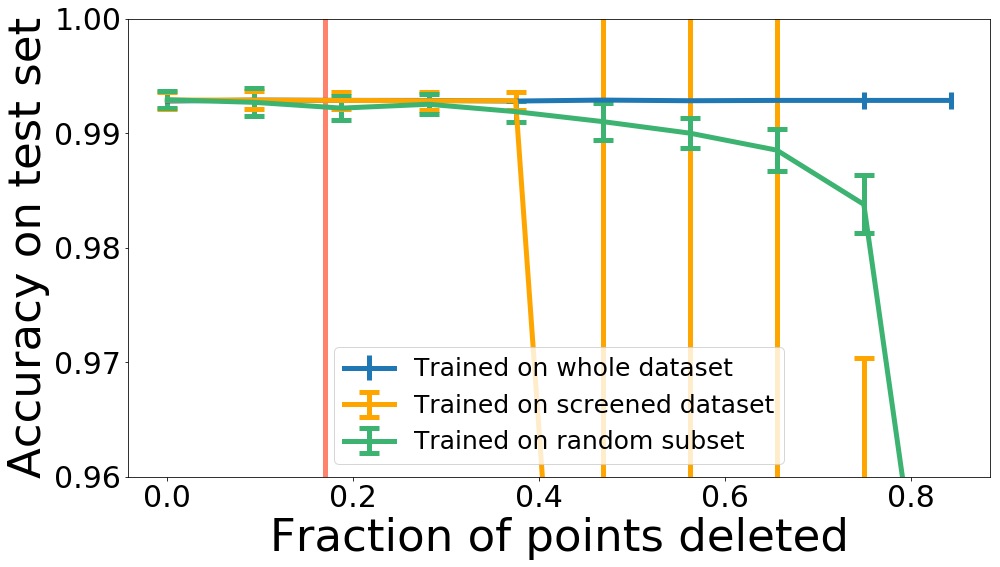

In [61]:
dir = '/sequoia/data1/gmialon/screening/results/mnist/'
exp = 'lmbda_0.01_n_ellipsoid_100_intercept_True_mu_10.0_cut_False_loss_hinge_penalty_l2_better_init_100_better_radius_0.1.npy'
data = np.load(dir + exp)
plot_experiment_(data, 11198, zoom=(0.96, 1), name='safe_mnist_9.pdf', save=True)

# Plot experiments

reverse_False_size_1000_lmbda_1_n_ellipsoid_100_intercept_False_mu_100_redundant_False_noise_0_loss_hinge_penalty_l2_better_init_100_better_radius_0.1.npy


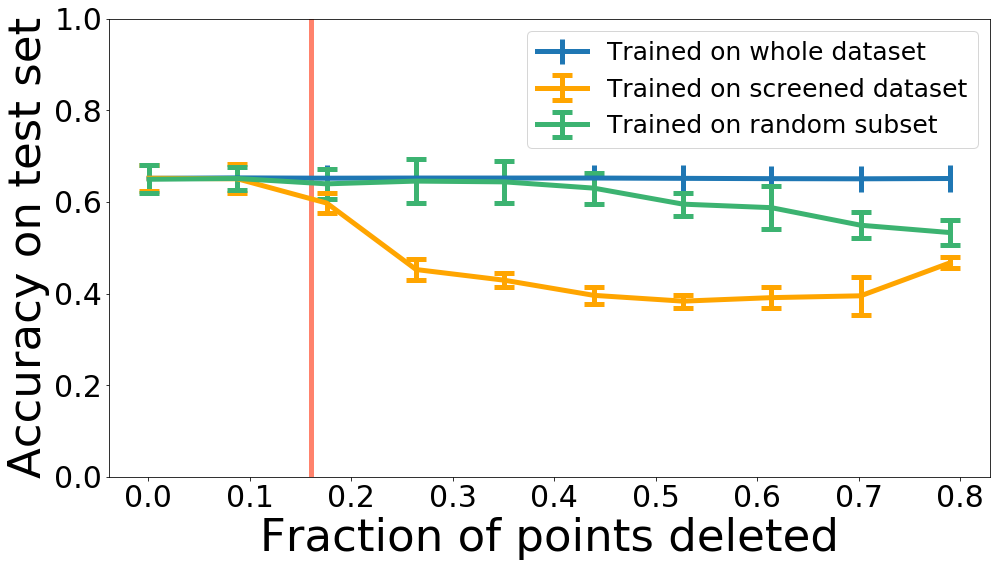

size_1000_lmbda_1_n_ellipsoid_100_intercept_False_mu_1_redundant_False_noise_0_loss_hinge_penalty_l2_better_init_10_better_radius_10.npy


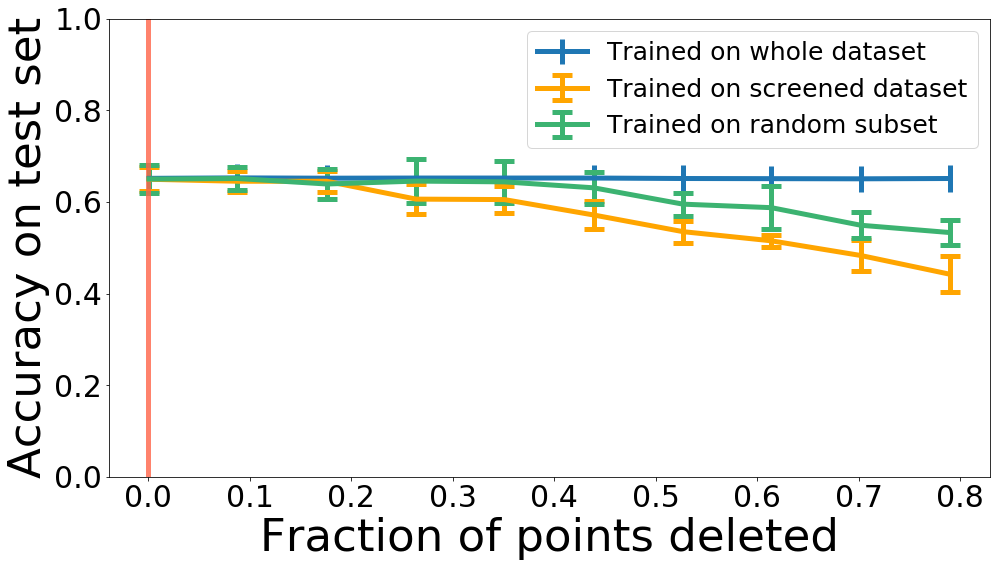

size_11779_lmbda_0.1_n_ellipsoid_1000_intercept_False_mu_1_redundant_0_noise_0_better_init_1_better_radius_2304.npy


ValueError: shape mismatch: objects cannot be broadcast to a single shape

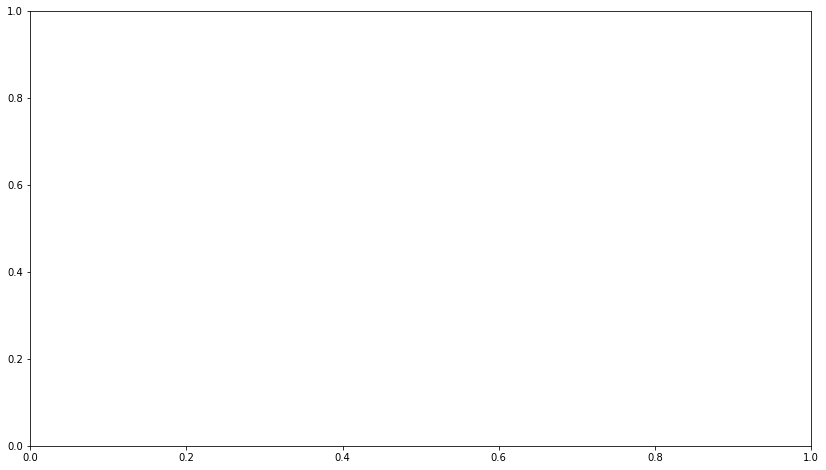

In [30]:
dir_cluster = '/sequoia/data1/gmialon/screening/results/'
exp = 'higgs'
for file in os.listdir(dir_cluster + exp):
    filename = os.fsdecode(file)
    print(filename)
    data = np.load(dir_cluster + exp + '/' + filename)
    plot_experiment_(data, 1000, zoom=(0,1))

# Higgs dataset

In [19]:
dir_higgs = '/sequoia/data1/gmialon/screening/datasets/higgs.small.p'
with open(dir_higgs, 'rb') as handle:
    data_higgs = pickle.load(handle)
X = data_higgs[0]
y =data_higgs[1]
X, _, y, _ = train_test_split(X, y, test_size=0.01)
print(X.shape, y.shape)
print(find_best_svm(X[:10000], y[:10000]))

(99000, 28) (99000,)
(LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 0.63570000000000004)


100 0.1 10000
Time to compute z and A: 8.482966899871826
ELLIPSOID CENTER [ 0.00686468 -0.07040435  0.02041604 -0.12100257 -0.03164443  0.14840608
 -0.04049679 -0.00064016  0.09327694  0.10776387  0.03912065  0.02143995
  0.0099921   0.10015813  0.01517276  0.00084996  0.00751423  0.15491592
  0.04364757 -0.06290911  0.0886074   0.02427344  0.09109411  0.14972377
  0.07111809 -0.25204483 -0.02910007 -0.10227843]
Time to rank the entire dataset: 0.6430909633636475
(8000, 28) (7999, 28) (7999, 28)
ESTIMATOR SOLUTION [[ -2.63071735e-01  -7.32014601e-02   3.16488477e-02  -4.08870625e-01
   -1.82111081e-02   8.23045267e-01  -3.21900054e-02   9.01125807e-03
    1.15376248e-01   2.51635529e-01   6.84622075e-02   3.30553565e-02
    1.72150412e-03   2.31684414e-01   2.50529486e-02  -1.46167125e-02
   -5.02039243e-02   2.89342292e-01   4.35221477e-02  -5.24226467e-02
    6.12986411e-04  -2.38517696e-01   8.40274392e-01   1.01954458e+00
    6.56112940e-01  -1.63050177e+00   2.88831125e+00  -4.650

(8000, 28) (4444, 28) (4444, 28)
ESTIMATOR SOLUTION [[ -2.84065083e-01  -8.38103600e-02   1.65377075e-02  -4.45869639e-01
   -1.33735840e-02   8.21739578e-01   2.05141285e-02  -4.35604417e-03
    1.01150478e-01   2.31954487e-01   1.03670351e-01   1.19188802e-02
    1.53635881e-03   2.22351894e-01   2.91358133e-02   6.30551159e-03
   -5.35352863e-02   2.41611245e-01   5.26213817e-02  -4.05599456e-02
   -1.76979983e-02  -2.44757249e-01   8.72212490e-01   1.03523235e+00
    6.45388158e-01  -1.62199413e+00   2.75943807e+00  -4.40197616e+00]]
NORM OF THE SOLUTION 5.75200310928
DIFF 16.21330497
(8000, 28) (3556, 28) (3556, 28)
ESTIMATOR SOLUTION [[ -2.83785827e-01  -8.49178850e-02   1.49563717e-02  -4.46117379e-01
   -1.14914738e-02   8.19108385e-01   2.32393337e-02  -4.04696025e-03
    1.00939314e-01   2.31402270e-01   1.03674254e-01   1.15432502e-02
    4.00026964e-03   2.26438945e-01   2.97705977e-02   4.05877657e-03
   -5.17946024e-02   2.41851832e-01   5.09850677e-02  -4.24281689e-02
  

(8000, 28) (889, 28) (889, 28)
ESTIMATOR SOLUTION [[ -2.53598961e-01  -8.47403764e-02   2.29207985e-02  -4.32495218e-01
    4.50006105e-03   8.41584336e-01  -1.12994372e-02   2.30139123e-03
    1.16058152e-01   2.50386023e-01   7.30079205e-02   1.53124776e-02
   -1.68514406e-02   2.24357912e-01   4.03027422e-02   9.97448502e-03
   -3.96332863e-02   2.67202892e-01   2.14401104e-02  -2.17528693e-02
   -9.87186711e-04  -1.93306781e-01   8.12812064e-01   9.99425362e-01
    6.85332588e-01  -1.62900887e+00   3.03618816e+00  -4.80843409e+00]]
NORM OF THE SOLUTION 6.19154031549
DIFF 101.10534918
Time to compute z and A: 12.903942584991455
ELLIPSOID CENTER [ 0.00106262 -0.07182798  0.03717104 -0.13560337  0.01323466  0.17736618
 -0.0122276   0.00863753  0.04162404  0.12631891 -0.00055464 -0.02483877
  0.02470129  0.11144041  0.02645182 -0.00649716 -0.01423088  0.16913864
  0.01488099 -0.06117751  0.07881013  0.02879607  0.09115799  0.13979509
  0.07047037 -0.2623107  -0.01803498 -0.09097726]
Ti

(8000, 28) (5333, 28) (5333, 28)
ESTIMATOR SOLUTION [[ -2.79469873e-01  -7.01490639e-02   1.17590396e-02  -4.93528066e-01
   -1.51968277e-02   8.27338974e-01  -1.95961623e-02  -3.64176581e-02
    1.23861257e-01   1.34077153e-01   9.25490392e-02  -2.02396015e-02
   -1.92904747e-02   2.41964788e-01   3.74563035e-02  -2.74917481e-04
   -3.27530528e-02   2.44016502e-01   2.07232192e-02  -4.04343288e-02
   -1.26792295e-02  -1.69476811e-01   7.67551260e-01   1.15052688e+00
    6.38903802e-01  -1.55083936e+00   2.98591455e+00  -4.72978406e+00]]
NORM OF THE SOLUTION 6.10082240663
DIFF 129.343808511
(8000, 28) (4444, 28) (4444, 28)
ESTIMATOR SOLUTION [[ -2.79654501e-01  -7.06256250e-02   1.14207248e-02  -4.91103575e-01
   -1.58443630e-02   8.26031694e-01  -2.25436963e-02  -3.50029828e-02
    1.26185266e-01   1.33483508e-01   9.35766915e-02  -2.29762681e-02
   -1.92854489e-02   2.47369888e-01   3.16721590e-02  -1.14179170e-03
   -3.47365372e-02   2.44170073e-01   2.40899290e-02  -4.22064383e-02


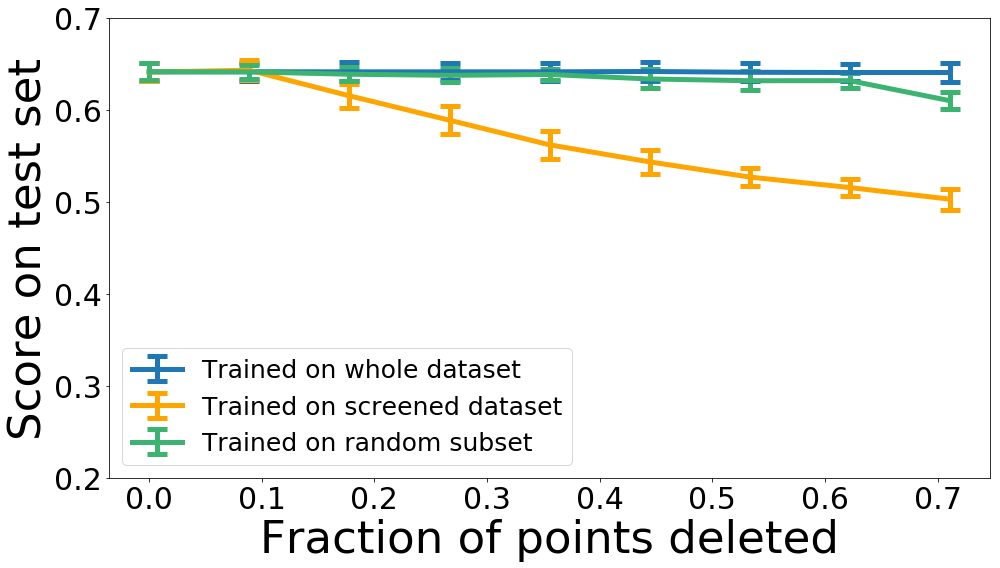

100 0.01 10000
Time to compute z and A: 10.36983847618103
ELLIPSOID CENTER [ -2.14601961e-01  -8.60839622e-02   2.06204928e-02  -4.68324314e-01
  -3.68589589e-02   5.28527613e-01  -1.45538485e-02   4.22671625e-04
   1.97813585e-01   2.33640680e-01   7.57011255e-02   5.63985765e-02
   3.19665799e-02   1.70068330e-01   3.31339499e-02  -2.63149249e-02
  -8.53432450e-02   2.75979468e-01   5.40089700e-02  -4.92354111e-02
   2.10729179e-02  -2.89542498e-02   3.67983837e-01   5.62063829e-01
   3.24303017e-01  -1.02020955e+00   3.19783906e-02  -7.48910217e-01]
Time to rank the entire dataset: 0.6961305141448975
(8000, 28) (7999, 28) (7999, 28)
ESTIMATOR SOLUTION [[ -2.72599923e-01  -8.17036526e-02   4.89735541e-02  -4.49168294e-01
   -3.05463928e-02   8.07429575e-01  -1.45951345e-02   2.22920916e-02
    1.29899920e-01   2.48358465e-01   1.06300141e-01   9.47349302e-03
    4.89650521e-02   2.05418268e-01  -8.51472298e-03   3.36650725e-03
    1.69935612e-02   2.44740329e-01   4.88377506e-02  -6.

(8000, 28) (3556, 28) (3556, 28)
ESTIMATOR SOLUTION [[ -3.36536534e-01  -6.22192465e-02   4.16313969e-02  -4.44683149e-01
    6.75991956e-03   7.84635549e-01   2.37198899e-02   1.48388210e-02
    1.16271901e-01   2.61540116e-01   7.29343069e-02  -1.04006426e-02
    4.54427999e-03   1.95943356e-01   8.16490377e-03  -1.37934935e-03
   -8.88448770e-02   2.67733215e-01   6.18273971e-02  -2.18687413e-02
    3.65658438e-02  -2.80026200e-01   9.00458897e-01   1.04961574e+00
    6.06391847e-01  -1.64747889e+00   2.69218826e+00  -4.39731549e+00]]
NORM OF THE SOLUTION 5.72723530804
DIFF 14.1651340146
(8000, 28) (2667, 28) (2667, 28)
ESTIMATOR SOLUTION [[ -3.00961573e-01  -6.17293621e-02   2.84965783e-02  -4.40083097e-01
   -1.18807963e-02   7.62325823e-01   4.96756167e-02  -1.29904958e-02
    1.12412471e-01   2.31562550e-01   8.34913864e-02   3.59773477e-02
    6.43449205e-03   2.41626448e-01   3.83859080e-02  -2.27564305e-03
   -5.20613000e-02   2.24979641e-01   3.72193519e-02   1.06231952e-02


Time to compute z and A: 8.65643835067749
Time to rank the entire dataset: 0.5915012359619141
(8000, 28) (7999, 28) (7999, 28)
ESTIMATOR SOLUTION [[ -2.97181316e-01  -3.44114997e-02  -4.22762501e-03  -4.64516572e-01
   -4.78236162e-02   8.47780484e-01  -4.48785971e-02   3.79986175e-02
    8.09153820e-02   2.93804142e-01   8.37335631e-02  -1.46285743e-02
    1.40755673e-02   2.54887997e-01   1.97830852e-02   1.32363461e-02
   -9.20392708e-03   3.20057017e-01   4.15695661e-02  -6.02769937e-02
   -1.13316048e-02  -3.42532034e-01   6.35246076e-01   1.05964518e+00
    5.54583635e-01  -1.69607329e+00   2.95074116e+00  -4.44351395e+00]]
NORM OF THE SOLUTION 5.8807515812
DIFF 19.3487727801
(8000, 28) (7111, 28) (7111, 28)
ESTIMATOR SOLUTION [[ -2.59512625e-01  -1.88507330e-02   2.86498092e-03  -4.64573401e-01
   -3.48333892e-02   8.98865060e-01  -1.74052075e-02   4.89285737e-02
    9.64212759e-02   2.85462087e-01   6.97583223e-02   4.86801728e-02
   -2.96679090e-03   2.61896956e-01   3.4291137

(8000, 28) (4444, 28) (4444, 28)
ESTIMATOR SOLUTION [[ -2.81385499e-01  -7.67214509e-02   9.49152655e-03  -5.03128750e-01
   -2.27226961e-02   8.23717838e-01   3.50976304e-02   3.38966751e-03
    1.11344993e-01   1.67402256e-01   9.11587832e-02  -8.88959284e-04
    6.95725878e-03   2.90594843e-01   3.63880369e-02  -1.45134069e-02
   -1.66570198e-02   2.56732019e-01   2.58720584e-03  -1.65986435e-02
   -1.95504411e-02  -1.92342148e-01   7.57867599e-01   1.18874404e+00
    6.09440433e-01  -1.49991672e+00   2.95481482e+00  -4.80809855e+00]]
NORM OF THE SOLUTION 6.14121798062
DIFF 26.5135370456
(8000, 28) (3556, 28) (3556, 28)
ESTIMATOR SOLUTION [[ -2.89002014e-01  -6.05401211e-02   4.52586954e-02  -5.35142254e-01
   -3.65157561e-02   8.49453786e-01  -1.29627175e-02  -1.17032669e-02
    9.64997963e-02   1.38546577e-01   8.31688680e-02  -6.62063365e-03
   -3.50337510e-02   2.83346757e-01   5.86957177e-02   4.40734419e-03
   -2.09943946e-02   1.94407759e-01   2.23581418e-02  -1.95946575e-02


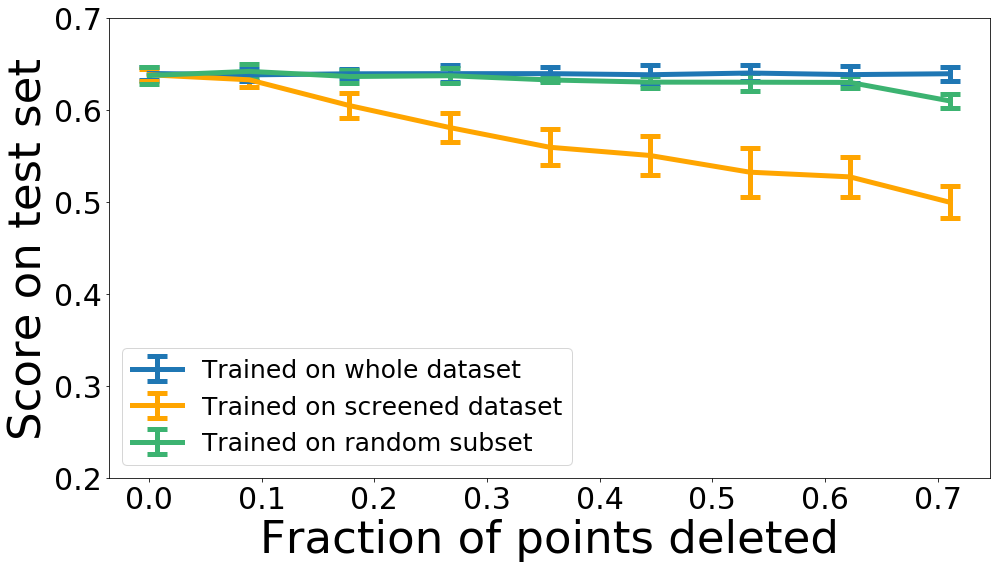

100 1 10000
Time to compute z and A: 8.865776777267456
ELLIPSOID CENTER [ 0.02869526 -0.03072595 -0.02851059 -0.00020006 -0.00307739  0.0439767
 -0.00115151 -0.00390885  0.07281589  0.06161056  0.00441185 -0.00379768
 -0.00151406  0.04428548 -0.02269677  0.01962306 -0.00744337  0.05233821
 -0.02720249 -0.02265593  0.03009151  0.02545567  0.04678948  0.04462139
  0.0135394   0.00848726  0.03841116 -0.00434257]
Time to rank the entire dataset: 0.6349849700927734
(8000, 28) (7999, 28) (7999, 28)
ESTIMATOR SOLUTION [[ -2.77136486e-01  -7.14303662e-02   3.06138373e-02  -4.37238074e-01
   -1.52662368e-02   8.10472895e-01  -3.14443836e-02   1.17657241e-02
    1.12958628e-01   2.42854010e-01   6.74256250e-02   3.27668511e-02
    2.09786197e-03   2.14245431e-01   2.23037243e-02  -1.15429779e-02
   -4.97601904e-02   2.92250346e-01   4.78368039e-02  -4.92627169e-02
   -2.49543027e-04  -2.29706048e-01   8.23325094e-01   1.03731508e+00
    6.50974436e-01  -1.59955018e+00   2.70409866e+00  -4.410386

(8000, 28) (4444, 28) (4444, 28)
ESTIMATOR SOLUTION [[ -2.96810143e-01  -8.17795757e-02   1.54482432e-02  -4.64021842e-01
   -1.19050219e-02   8.09397252e-01   2.06549086e-02  -9.12939274e-03
    1.02147718e-01   2.30076437e-01   1.04944709e-01   7.57248095e-03
    3.84484759e-03   2.20195023e-01   2.75914221e-02   1.90065040e-03
   -5.76520473e-02   2.37399240e-01   4.84234937e-02  -3.92548237e-02
   -1.90431084e-02  -2.42507846e-01   8.69599529e-01   1.03672088e+00
    6.31835689e-01  -1.61241762e+00   2.54585021e+00  -4.09526020e+00]]
NORM OF THE SOLUTION 5.41250133889
DIFF 8.96168983925
(8000, 28) (3556, 28) (3556, 28)
ESTIMATOR SOLUTION [[ -2.99136949e-01  -8.39885738e-02   1.46577427e-02  -4.66646762e-01
   -1.10644574e-02   8.22729018e-01   2.28888814e-02  -1.06933975e-02
    1.03681211e-01   2.30899477e-01   1.06291839e-01   9.03653853e-03
    4.41069927e-03   2.24518549e-01   2.71153756e-02   3.49129128e-03
   -5.59238768e-02   2.43399169e-01   4.99184729e-02  -3.79293137e-02


Time to compute z and A: 13.17870569229126
ELLIPSOID CENTER [  3.05113363e-02  -9.37133772e-03   1.87190711e-03  -3.06621569e-02
   3.28696110e-02   2.86982195e-02  -1.21268100e-02  -3.10398192e-04
   1.24139054e-02   4.65751207e-02   1.97464698e-02  -3.17529811e-02
   2.27095606e-03   5.62618956e-02  -1.82411738e-02   5.32228228e-03
  -9.96123745e-05   6.93606959e-03   3.82722439e-03  -1.54442346e-02
   6.04192561e-02   6.68622445e-03   3.41789015e-02   3.11072730e-02
   2.57326685e-03  -2.43950176e-02   3.65968677e-02   3.45517650e-02]
Time to compute z and A: 12.719768524169922
Time to rank the entire dataset: 0.6767563819885254
(8000, 28) (7999, 28) (7999, 28)
ESTIMATOR SOLUTION [[ -3.06490651e-01  -6.91376563e-02   1.40599120e-02  -4.64368097e-01
   -1.58088366e-02   8.43871389e-01  -4.28124117e-02   2.17715895e-02
    8.67872991e-02   2.68633586e-01   8.01597087e-02   1.45144416e-02
   -7.71339466e-04   2.43119221e-01   1.72499644e-02   7.79786663e-03
   -3.01921211e-02   2.72652

(8000, 28) (5333, 28) (5333, 28)
ESTIMATOR SOLUTION [[ -2.91650740e-01  -6.97830415e-02   1.10771432e-02  -5.07960852e-01
   -1.73677926e-02   8.12949927e-01  -2.57675299e-02  -3.13644770e-02
    1.30912476e-01   1.30203678e-01   9.38066445e-02  -2.38809089e-02
   -1.84896089e-02   2.59053940e-01   3.52096171e-02   2.23310233e-03
   -3.39118670e-02   2.43079430e-01   2.34580438e-02  -4.32543318e-02
   -1.66314323e-02  -1.62833882e-01   7.44985015e-01   1.14957850e+00
    6.38440189e-01  -1.52591649e+00   2.77197994e+00  -4.45926681e+00]]
NORM OF THE SOLUTION 5.77875542501
DIFF 9.51744133358
(8000, 28) (4444, 28) (4444, 28)
ESTIMATOR SOLUTION [[ -2.93858344e-01  -6.96019096e-02   1.24051740e-02  -5.10122392e-01
   -1.72185559e-02   8.14553243e-01  -2.51221718e-02  -3.00577789e-02
    1.32248734e-01   1.33057271e-01   9.26480483e-02  -2.31403533e-02
   -1.85618834e-02   2.61562560e-01   3.51490351e-02   2.32417839e-03
   -3.30517324e-02   2.44670937e-01   2.41464801e-02  -4.31127348e-02


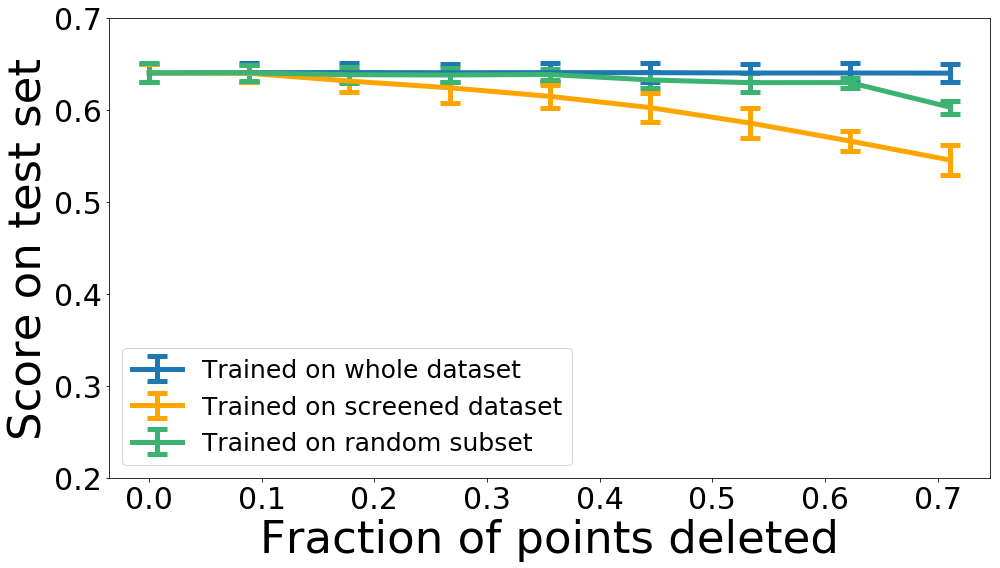

1000 0.1 10000
Time to compute z and A: 86.91287636756897
ELLIPSOID CENTER [  1.32715817e-02  -6.56747707e-02   1.05991352e-02  -1.11363646e-01
  -1.76092198e-02   1.44602866e-01  -2.70887647e-03   2.09952867e-03
   1.15592786e-01   1.19421273e-01   1.42497810e-02   1.96416078e-02
   2.65392451e-02   7.29539503e-02   1.54936368e-04  -1.56865547e-02
   1.15889426e-02   1.39711267e-01   5.35881773e-02  -1.23210534e-02
   8.20739080e-02   4.35059625e-02   8.78469529e-02   1.49997044e-01
   7.43292264e-02  -2.27743336e-01  -2.18464924e-02  -9.49613495e-02]
Time to rank the entire dataset: 1.2046005725860596
(8000, 28) (7999, 28) (7999, 28)
ESTIMATOR SOLUTION [[ -2.63071735e-01  -7.32014601e-02   3.16488477e-02  -4.08870625e-01
   -1.82111081e-02   8.23045267e-01  -3.21900054e-02   9.01125807e-03
    1.15376248e-01   2.51635529e-01   6.84622075e-02   3.30553565e-02
    1.72150412e-03   2.31684414e-01   2.50529486e-02  -1.46167125e-02
   -5.02039243e-02   2.89342292e-01   4.35221477e-02  -5.

(8000, 28) (4444, 28) (4444, 28)
ESTIMATOR SOLUTION [[ -2.84065083e-01  -8.38103600e-02   1.65377075e-02  -4.45869639e-01
   -1.33735840e-02   8.21739578e-01   2.05141285e-02  -4.35604417e-03
    1.01150478e-01   2.31954487e-01   1.03670351e-01   1.19188802e-02
    1.53635881e-03   2.22351894e-01   2.91358133e-02   6.30551159e-03
   -5.35352863e-02   2.41611245e-01   5.26213817e-02  -4.05599456e-02
   -1.76979983e-02  -2.44757249e-01   8.72212490e-01   1.03523235e+00
    6.45388158e-01  -1.62199413e+00   2.75943807e+00  -4.40197616e+00]]
NORM OF THE SOLUTION 5.75200310928
DIFF 15.5310021563
(8000, 28) (3556, 28) (3556, 28)
ESTIMATOR SOLUTION [[ -2.83785827e-01  -8.49178850e-02   1.49563717e-02  -4.46117379e-01
   -1.14914738e-02   8.19108385e-01   2.32393337e-02  -4.04696025e-03
    1.00939314e-01   2.31402270e-01   1.03674254e-01   1.15432502e-02
    4.00026964e-03   2.26438945e-01   2.97705977e-02   4.05877657e-03
   -5.17946024e-02   2.41851832e-01   5.09850677e-02  -4.24281689e-02


(8000, 28) (889, 28) (889, 28)
ESTIMATOR SOLUTION [[ -2.53598961e-01  -8.47403764e-02   2.29207985e-02  -4.32495218e-01
    4.50006105e-03   8.41584336e-01  -1.12994372e-02   2.30139123e-03
    1.16058152e-01   2.50386023e-01   7.30079205e-02   1.53124776e-02
   -1.68514406e-02   2.24357912e-01   4.03027422e-02   9.97448502e-03
   -3.96332863e-02   2.67202892e-01   2.14401104e-02  -2.17528693e-02
   -9.87186711e-04  -1.93306781e-01   8.12812064e-01   9.99425362e-01
    6.85332588e-01  -1.62900887e+00   3.03618816e+00  -4.80843409e+00]]
NORM OF THE SOLUTION 6.19154031549
DIFF 70.0334292487
Time to compute z and A: 88.54633903503418
ELLIPSOID CENTER [ 0.01405445 -0.07569975 -0.00465235 -0.14534961 -0.01720158  0.14091122
 -0.01546106  0.02047266  0.05716835  0.1212847   0.03579284 -0.01448845
 -0.02114473  0.10593894 -0.00189539  0.00233498  0.00290861  0.13902204
  0.01825129 -0.03496513  0.10172855  0.04108615  0.09797894  0.13963327
  0.05927651 -0.26535715 -0.03569871 -0.06971854]
Ti

(8000, 28) (5333, 28) (5333, 28)
ESTIMATOR SOLUTION [[ -2.79469873e-01  -7.01490639e-02   1.17590396e-02  -4.93528066e-01
   -1.51968277e-02   8.27338974e-01  -1.95961623e-02  -3.64176581e-02
    1.23861257e-01   1.34077153e-01   9.25490392e-02  -2.02396015e-02
   -1.92904747e-02   2.41964788e-01   3.74563035e-02  -2.74917481e-04
   -3.27530528e-02   2.44016502e-01   2.07232192e-02  -4.04343288e-02
   -1.26792295e-02  -1.69476811e-01   7.67551260e-01   1.15052688e+00
    6.38903802e-01  -1.55083936e+00   2.98591455e+00  -4.72978406e+00]]
NORM OF THE SOLUTION 6.10082240663
DIFF 7.94465606297
(8000, 28) (4444, 28) (4444, 28)
ESTIMATOR SOLUTION [[ -2.79654501e-01  -7.06256250e-02   1.14207248e-02  -4.91103575e-01
   -1.58443630e-02   8.26031694e-01  -2.25436963e-02  -3.50029828e-02
    1.26185266e-01   1.33483508e-01   9.35766915e-02  -2.29762681e-02
   -1.92854489e-02   2.47369888e-01   3.16721590e-02  -1.14179170e-03
   -3.47365372e-02   2.44170073e-01   2.40899290e-02  -4.22064383e-02


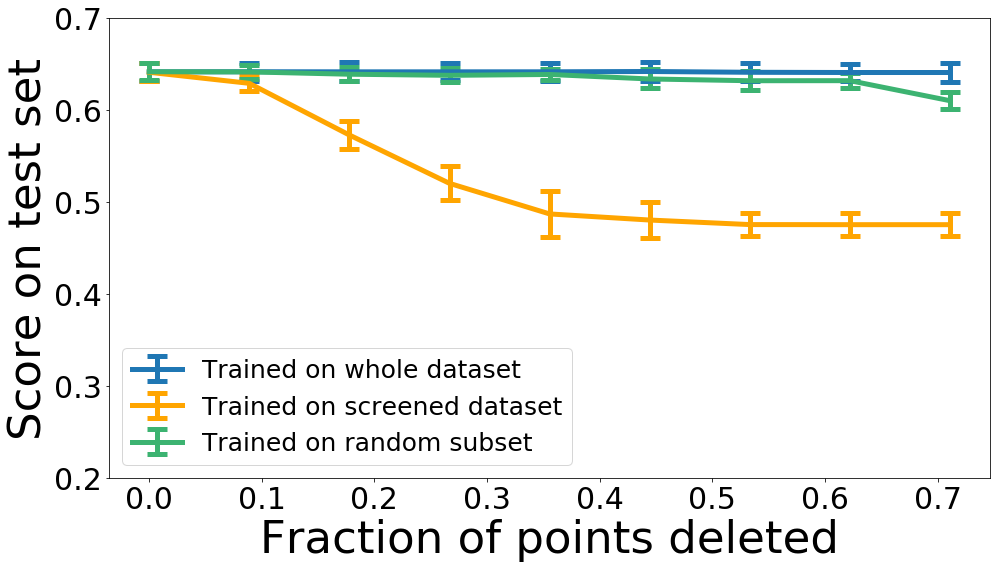

1000 0.01 10000
Time to compute z and A: 122.21323037147522
ELLIPSOID CENTER [ -2.34564220e-01  -9.41839455e-02   1.63032672e-02  -4.52242448e-01
  -3.41721113e-02   5.30713668e-01  -1.44656746e-02   4.25836239e-03
   1.74858386e-01   2.42546190e-01   6.39622216e-02   2.58698124e-02
   1.37612281e-02   1.47199943e-01   1.86048162e-02  -9.81133932e-04
  -4.25946512e-02   2.79906671e-01   6.18089584e-02  -3.12462377e-02
   3.84677441e-02  -1.92869144e-02   3.81737004e-01   5.79050719e-01
   3.11475973e-01  -1.03065109e+00   6.82979266e-02  -7.61051753e-01]
Time to rank the entire dataset: 1.3264515399932861
(8000, 28) (7999, 28) (7999, 28)
ESTIMATOR SOLUTION [[ -2.72599923e-01  -8.17036526e-02   4.89735541e-02  -4.49168294e-01
   -3.05463928e-02   8.07429575e-01  -1.45951345e-02   2.22920916e-02
    1.29899920e-01   2.48358465e-01   1.06300141e-01   9.47349302e-03
    4.89650521e-02   2.05418268e-01  -8.51472298e-03   3.36650725e-03
    1.69935612e-02   2.44740329e-01   4.88377506e-02  -

(8000, 28) (3556, 28) (3556, 28)
ESTIMATOR SOLUTION [[ -3.36536534e-01  -6.22192465e-02   4.16313969e-02  -4.44683149e-01
    6.75991956e-03   7.84635549e-01   2.37198899e-02   1.48388210e-02
    1.16271901e-01   2.61540116e-01   7.29343069e-02  -1.04006426e-02
    4.54427999e-03   1.95943356e-01   8.16490377e-03  -1.37934935e-03
   -8.88448770e-02   2.67733215e-01   6.18273971e-02  -2.18687413e-02
    3.65658438e-02  -2.80026200e-01   9.00458897e-01   1.04961574e+00
    6.06391847e-01  -1.64747889e+00   2.69218826e+00  -4.39731549e+00]]
NORM OF THE SOLUTION 5.72723530804
DIFF 10.6552893636
(8000, 28) (2667, 28) (2667, 28)
ESTIMATOR SOLUTION [[ -3.00961573e-01  -6.17293621e-02   2.84965783e-02  -4.40083097e-01
   -1.18807963e-02   7.62325823e-01   4.96756167e-02  -1.29904958e-02
    1.12412471e-01   2.31562550e-01   8.34913864e-02   3.59773477e-02
    6.43449205e-03   2.41626448e-01   3.83859080e-02  -2.27564305e-03
   -5.20613000e-02   2.24979641e-01   3.72193519e-02   1.06231952e-02


Time to compute z and A: 115.1923475265503
Time to rank the entire dataset: 1.2553112506866455
(8000, 28) (7999, 28) (7999, 28)
ESTIMATOR SOLUTION [[ -2.97181316e-01  -3.44114997e-02  -4.22762501e-03  -4.64516572e-01
   -4.78236162e-02   8.47780484e-01  -4.48785971e-02   3.79986175e-02
    8.09153820e-02   2.93804142e-01   8.37335631e-02  -1.46285743e-02
    1.40755673e-02   2.54887997e-01   1.97830852e-02   1.32363461e-02
   -9.20392708e-03   3.20057017e-01   4.15695661e-02  -6.02769937e-02
   -1.13316048e-02  -3.42532034e-01   6.35246076e-01   1.05964518e+00
    5.54583635e-01  -1.69607329e+00   2.95074116e+00  -4.44351395e+00]]
NORM OF THE SOLUTION 5.8807515812
DIFF 6.00386013759
(8000, 28) (7111, 28) (7111, 28)
ESTIMATOR SOLUTION [[ -2.59512625e-01  -1.88507330e-02   2.86498092e-03  -4.64573401e-01
   -3.48333892e-02   8.98865060e-01  -1.74052075e-02   4.89285737e-02
    9.64212759e-02   2.85462087e-01   6.97583223e-02   4.86801728e-02
   -2.96679090e-03   2.61896956e-01   3.429113

KeyboardInterrupt: 

In [28]:
for n_ell_steps in [100, 1000, 10000]:
    for lmbda in [0.1, 0.01, 1]:
        for size in [10000]:
            print(n_ell_steps, lmbda, size)
            experiment(path='./', dataset='higgs', size=size, redundant=0, noise=0, nb_delete_steps=10, 
    lmbda=lmbda, mu=1, classification=True, loss='hinge', penalty='l2', intercept=False, classif_score=True, 
    n_ellipsoid_steps=n_ell_steps, better_init=1, better_radius=28, cut=True, nb_exp=5, nb_test=3, zoom= [0.2, 0.7])

In [ ]:
for n_ell_steps in [100, 1000, 10000]:
    for lmbda in [0.1, 0.01, 1]:
        for size in [100000]:
            print(n_ell_steps, lmbda, size)
            experiment(path='./', dataset='higgs', size=size, redundant=0, noise=0, nb_delete_steps=10, 
    lmbda=lmbda, mu=1, classification=True, loss='hinge', penalty='l2', intercept=False, classif_score=True, 
    n_ellipsoid_steps=n_ell_steps, better_init=1, better_radius=28, cut=True, nb_exp=5, nb_test=3, zoom= [0.2, 0.7])